### 군집화 정리
- GMM, DBSCAN
- 확률 기반 군집화

---
- K-means는 거리가반 알고리즘
- GMM (Gaussian Mixture Model)
- 가우시안 분포, 정규분포 개념으로 이해하고, 군집들이 정규분포 안에 속해 있다는 가정으로
- 속해있을 확률을 통해서 군집화를 진행하는 것이 GMM 작동하는 원리인 EM 알고리즘
- 2개 또는 3개 이상의 정규분포가 있고 그 정규분포들이 겹쳐져 있다고 생각한다면
- A라는 정규분포와 B라는 정규분포, C라는 정규분포가 있을 때 합쳐져 있다고 가정하고 -> 데이터의 분포가 결국 하나의 정규분포 안에 속할 것이라 판단하는 것

---
- 확률과 우도의 차이
- 최대우도법
- 우도 -> ?
- 확률은 분포가 정해지고 난 후라는 것, 분포의 모수가 정해진 경우에서 관측치가 나올 가능성
- 우도는 분포가 정해지고 난 후 관측치가 주어졌을 때 모수가 나올 가능성
- EM 알고리즘에 대한 원리를 확인해 보시는 걸 추천드립니다!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4, 
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

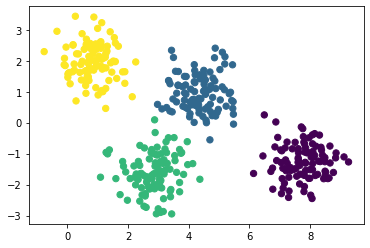

In [3]:
# Plot the data with K means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis")

In [4]:
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    # plot the input data
    ax = ax or plt.gca()
    ax.axis("equal")
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis", zorder=2)
    
    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() 
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc="#CCCCCC", lw=3, alpha=0.5, zorder=1))

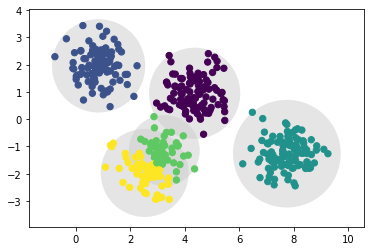

In [5]:
kmeans = KMeans(n_clusters=5, random_state=0)
plot_kmeans(kmeans, X)

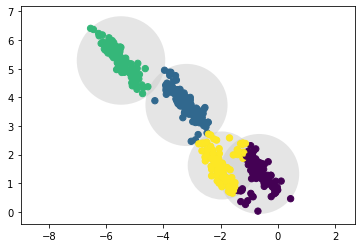

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

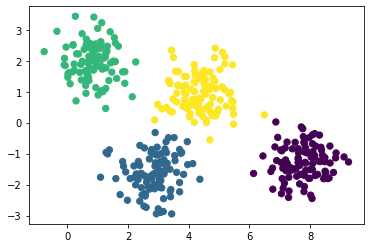

In [7]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis")

In [9]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.469 0.    0.    0.531]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]]


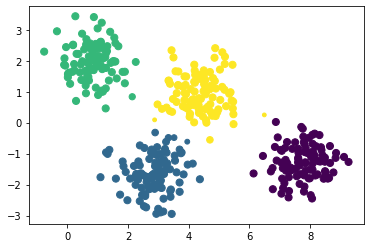

In [11]:
size = 50 * probs.max(1) ** 2 # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, s=size, cmap="viridis")

In [14]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """ Draw an ellipse with a given position and covariance """
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, 
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis", zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis("equal")
    
    w_factor = 0.2 / gmm.weights_.max()
    
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

- covariance_type="full" <- 타입에 따라서 다르게 평가할 수 있다.
- covariance_type="diag"
- covariance_type="spherical"

- Kmeans의 경우는 원형으로 데이터를 군집화한다.
- 만약 데이터의 형태가 아래와 같이 타원형이거나 불규칙적인 경우
- Kmeans로 하게되면 잘 군집화가 되지 않을 수 있다.
- GMM의 경우는 데이터의 분포에 따라 파라미터를 조정할 수 있어서 다양한 형태의 데이터에서도 군집화가 진행 가능하다.
- 군집의 특성 및 군집의 개수를 잘 파악해서 군집의 평가를 진행한다.
- Kmeans의 경우는 실루엣, 엘보우 등으로 파악했고
- GMM의 경우는 AIC, BIC의 값으로도 평가를 한다.
- 각 군집마다 평가하는 방식이 다르고, 가장 중요한 건 비지도 학습 군집화를 진행할 때 데이터의 분포를 먼저 확인하고 접근하는 것이다.

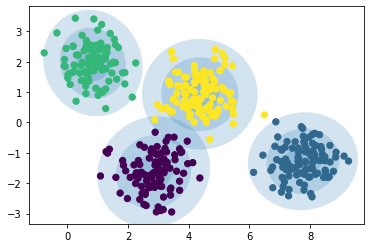

In [15]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

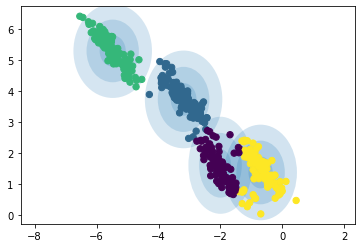

In [16]:
gmm = GMM(n_components=4, covariance_type="diag", random_state=42)
plot_gmm(gmm, X_stretched)

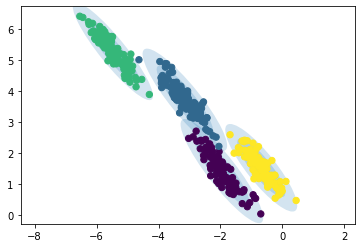

In [17]:
gmm = GMM(n_components=4, covariance_type="full", random_state=42)
plot_gmm(gmm, X_stretched)

#### Choosing the covariance type
If you look at the details of the preceding fits, you will see that the covariance_type option was set differently within each. This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem. The default is covariance_type="diag", which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes. A slightly simpler and faster model is covariance_type="spherical", which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of k-means, though it is not entirely equivalent. A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use covariance_type="full", which allows each cluster to be modeled as an ellipse with arbitrary orientation.

Text(0.5, 0, 'n_components')

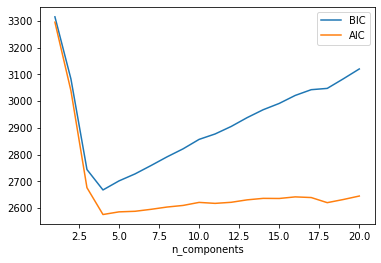

In [18]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type="full", random_state=0).fit(X) 
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label="BIC")
plt.plot(n_components, [m.aic(X) for m in models], label="AIC")
plt.legend(loc="best")
plt.xlabel("n_components")

### 군집화에 대한 적용
- 군집화에 대한 잘못된 방법 중 하나가 의미없이 모든 변수들을 다 사용하는 것
- 이런 부분을 해결하기 위해서 특성을 뽑는 차원 축소 등을 하기도 한다.
- 도메인을 가지고 분석을 진행한 후에 군집화를 하는 경우도 많다.
- 도메인 부분이 중요한 역할을 한다.